In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from matplotlib import rcParams

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() !=None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Plot tree containing only two covariates
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from matplotlib.colors import ListedColormap
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_2tree(ax, Xtr, Xte, ytr, yte, clf, plot_train = True, plot_test = True, lab = ['Feature 1', 'Feature 2'], mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    # Create a meshgrid as our test data
    plt.figure(figsize=(15,10))
    plot_step= 0.05
    xmin, xmax= Xtr[:,0].min(), Xtr[:,0].max()
    ymin, ymax= Xtr[:,1].min(), Xtr[:,1].max()
    xx, yy = np.meshgrid(np.arange(xmin, xmax, plot_step), np.arange(ymin, ymax, plot_step) )

    # Re-cast every coordinate in the meshgrid as a 2D point
    Xplot= np.c_[xx.ravel(), yy.ravel()]


    # Predict the class
    Z = clfTree1.predict( Xplot )

    # Re-shape the results
    Z= Z.reshape( xx.shape )
    cs = plt.contourf(xx, yy, Z, cmap= cmap_light, alpha=0.3)
  
    # Overlay training samples
    if (plot_train == True):
        plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, alpha=alpha,edgecolor="k") 
    # and testing points
    if (plot_test == True):
        plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s")

    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.title("Boundary for decision tree classifier",fontsize=7.5)

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


(1599, 12)


(array([ 10.,   0.,  53.,   0., 681.,   0., 638.,   0., 199.,  18.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <a list of 10 Patch objects>)

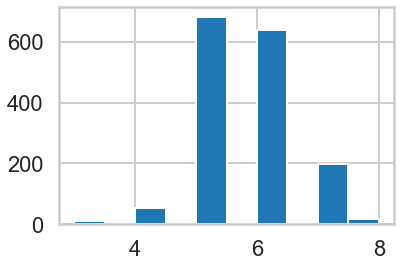

In [4]:
print (df.shape)

plt.hist(df.quality)

In [5]:
Y = df['quality'].values
df_tmp = df.drop('quality',1)
Y = np.array([1 if y>=7 else 0 for y in Y])
X = df_tmp.as_matrix()

df['target'] = (df['quality'].values >=7)*1

c:\python\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [6]:
Xnames = list(df.columns.values[1:11])

In [7]:

np.mean(df['target'])

0.1357098186366479

In [8]:

itrain, itest = train_test_split(range(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [9]:
print ("% Good wines in Training:", np.mean(df.target[mask]))
print ("% Good wines in Testing:", np.mean(df.target[~mask]))

% Good wines in Training: 0.1334723670490094
% Good wines in Testing: 0.1390625


In [11]:
from sklearn import tree
clfTree1 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1, parameters, df, 
                                                     ['alcohol', 'fixed acidity'],'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask
BEST {'max_depth': 6, 'min_samples_leaf': 1} 0.4009927146681441 {'mean_fit_time': array([0.00108557, 0.0039927 , 0.00180273, 0.00226016, 0.00160751,
       0.00080047, 0.00078664, 0.00275841, 0.00224366, 0.00137448,
       0.00103464, 0.00080438, 0.00211258, 0.00263028, 0.0009923 ,
       0.00219464, 0.00220089, 0.00039725, 0.00230851, 0.00224385,
       0.00043216, 0.00267558, 0.00088067, 0.00030222, 0.00020194,
       0.00580606, 0.00140023, 0.00184088, 0.00281653, 0.00218554,
       0.00188046, 0.0029952 , 0.00140004, 0.00113158, 0.00286236,
       0.00149956, 0.00259619, 0.0013267 , 0.00162859, 0.00286427,
       0.00090694, 0.00195312]), 'std_fit_time': array([0.00171593, 0.00471416, 0.00134928, 0.00146681, 0.00171239,
       0.00040026, 0.00114193, 0.0015934 , 0.00184535, 0.00137133,
       0.00173815, 0.00075541, 0.00170694, 0.00098196, 0.00123824,
       0.00133778, 0.00282996, 0.00048672, 0.00172575, 0.00158439,
       0.00053184, 0.00370339, 0.0007976 , 0.00060444,

c:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


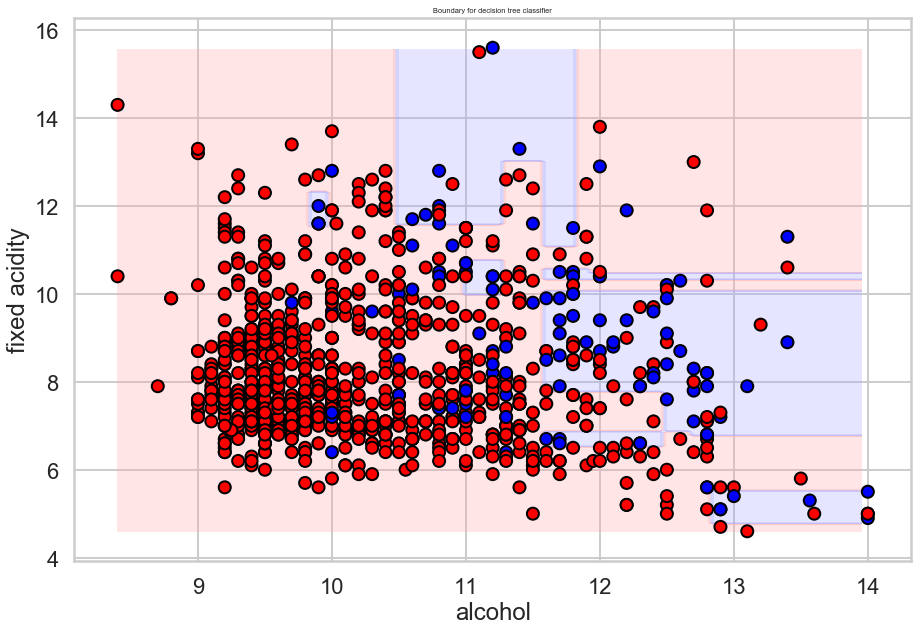

In [12]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_test = False)

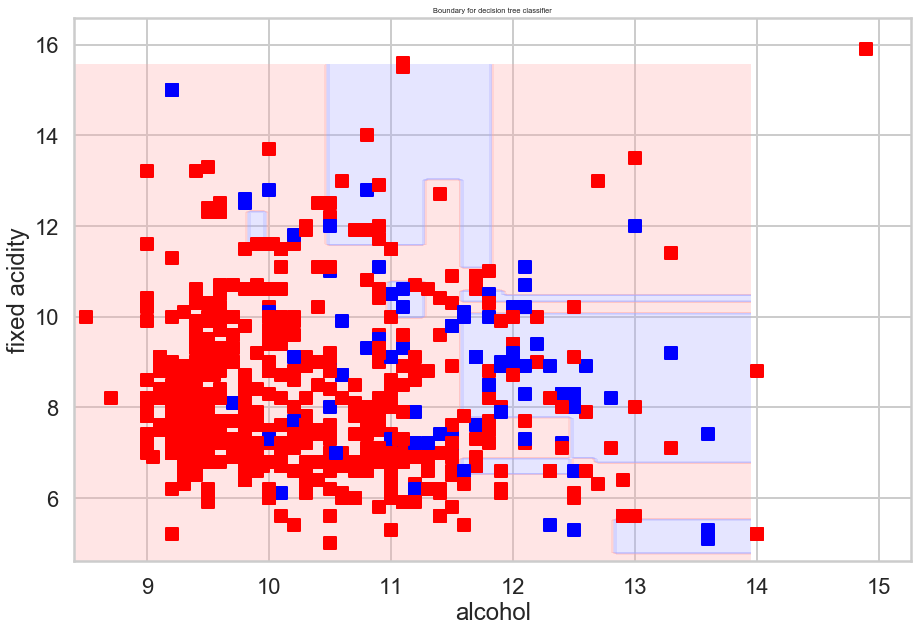

In [13]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_train = False)

using mask
BEST {'max_depth': None, 'min_samples_leaf': 5} 0.3314062354813029 {'mean_fit_time': array([0.00249224, 0.00279799, 0.00089426]), 'std_fit_time': array([0.00207735, 0.00193917, 0.00134567]), 'mean_score_time': array([0.0036653 , 0.00320072, 0.00291419]), 'std_score_time': array([0.00334583, 0.00160038, 0.00155664]), 'param_max_depth': masked_array(data=[None, None, None],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_leaf': masked_array(data=[4, 5, 6],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': None, 'min_samples_leaf': 4}, {'max_depth': None, 'min_samples_leaf': 5}, {'max_depth': None, 'min_samples_leaf': 6}], 'split0_test_score': array([0.36842105, 0.37837838, 0.32432432]), 'split1_test_score': array([0.34042553, 0.31372549, 0.22727273]), 'split2_test_score': array([0.34146341, 0.45454545, 0.27777778]), 'split3_test_score': array([0.23728

c:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


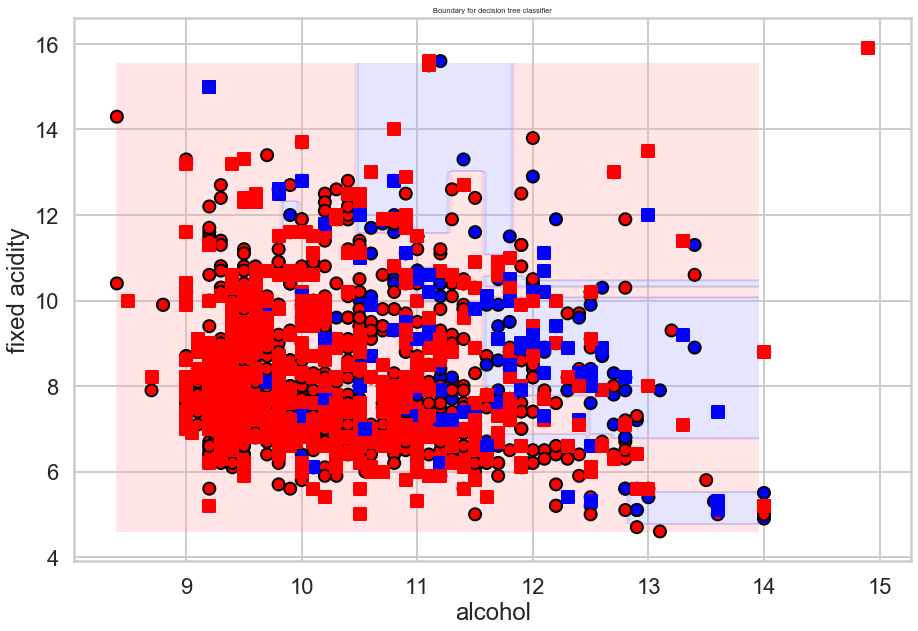

In [14]:
from sklearn import tree
clfTree_temp = tree.DecisionTreeClassifier()

parameters = {"max_depth": [None], 'min_samples_leaf': [4, 5, 6]}
clfTree_temp, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree_temp, parameters, df, 
                                                     ['alcohol', 'fixed acidity'],'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree_temp, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_train = True)

In [15]:
clfTree2 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
clfTree2, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree2, parameters, df, 
                                                     Xnames,'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask
BEST {'max_depth': 6, 'min_samples_leaf': 6} 0.40930472959670045 {'mean_fit_time': array([0.00169992, 0.00499239, 0.00296917, 0.00360398, 0.00119958,
       0.00310678, 0.00504713, 0.00358953, 0.00265012, 0.00223985,
       0.0047657 , 0.00304184, 0.00217957, 0.00220666, 0.00143394,
       0.00206866, 0.00325718, 0.00372748, 0.00391288, 0.00333533,
       0.0054038 , 0.00692425, 0.00547419, 0.00661273, 0.00426497,
       0.00512667, 0.00663514, 0.00719099, 0.00399561, 0.0042038 ,
       0.00905285, 0.01038675, 0.00399442, 0.00958738, 0.00559263,
       0.00719018, 0.00885472, 0.00503531, 0.00639162, 0.00798883,
       0.00562496, 0.00836239, 0.00733032, 0.00725045, 0.00585051,
       0.00799236, 0.00728641, 0.00776057, 0.00959907, 0.01196885,
       0.00978808, 0.00819888, 0.00908537, 0.00719261, 0.00838771,
       0.0082005 , 0.00828457, 0.00798931, 0.00748472, 0.00798931,
       0.00886574, 0.00927219, 0.01220937, 0.00908384, 0.00556059,
       0.0064754 , 0.00997252, 0.00

c:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [16]:
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()

parameters = {"n_estimators": range(1, 20)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask
BEST {'n_estimators': 9} 0.38727826631648016 {'mean_fit_time': array([0.01026859, 0.00937095, 0.01821723, 0.0234066 , 0.02419462,
       0.02912483, 0.0405251 , 0.04029937, 0.04749537, 0.04987683,
       0.05215926, 0.0592144 , 0.065767  , 0.06489811, 0.06939325,
       0.06921959, 0.07468605, 0.06742816, 0.05721965]), 'std_fit_time': array([0.00581006, 0.00765135, 0.00450044, 0.00655333, 0.00473275,
       0.0063192 , 0.01283983, 0.00428718, 0.00119025, 0.00295411,
       0.00450121, 0.00718718, 0.00760753, 0.00205762, 0.006885  ,
       0.0040616 , 0.00809191, 0.01686624, 0.01179631]), 'mean_score_time': array([0.00750694, 0.00312438, 0.00319824, 0.00839839, 0.00474629,
       0.00312414, 0.00367894, 0.00219188, 0.        , 0.00392542,
       0.0089992 , 0.0094636 , 0.0055851 , 0.0068181 , 0.00864911,
       0.00249152, 0.00926781, 0.00937304, 0.00660801]), 'std_score_time': array([0.00441323, 0.00624876, 0.00159913, 0.00528631, 0.00573285,
       0.00624828, 0.00687089, 0

c:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


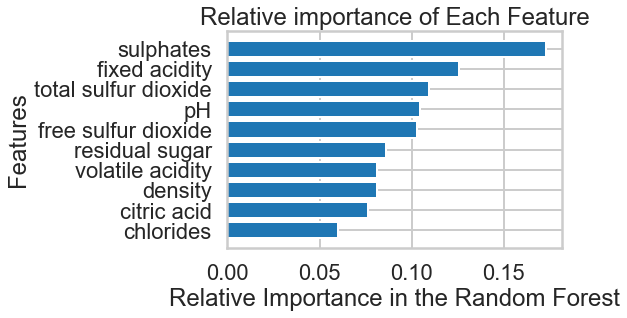

In [17]:
importance_list = clfForest.feature_importances_
name_list = df.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [18]:
from sklearn.ensemble import AdaBoostClassifier

clfAda = AdaBoostClassifier()

parameters = {"n_estimators": range(10, 60)}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


c:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BEST {'n_estimators': 47} 0.41317954367779586 {'mean_fit_time': array([0.05552754, 0.06557913, 0.05175757, 0.05581288, 0.05665812,
       0.07813287, 0.07195373, 0.08123178, 0.08357234, 0.09491029,
       0.0966187 , 0.10778627, 0.10967851, 0.11383805, 0.11880522,
       0.11815939, 0.11552968, 0.12626452, 0.13692565, 0.13080955,
       0.13999052, 0.13829484, 0.14316077, 0.15220842, 0.15778255,
       0.16074877, 0.15843401, 0.16664743, 0.164745  , 0.17452297,
       0.1872437 , 0.19105191, 0.18900948, 0.19930782, 0.20460162,
       0.20791473, 0.21241841, 0.21410041, 0.21685786, 0.22276521,
       0.22632251, 0.24085817, 0.23803363, 0.23499212, 0.24481769,
       0.24893203, 0.2554172 , 0.24784784, 0.26522679, 0.25926867]), 'std_fit_time': array([0.00952877, 0.01368812, 0.00502036, 0.00601575, 0.00981808,
       0.01505067, 0.00629843, 0.00470175, 0.00630212, 0.00270543,
       0.01061881, 0.00884219, 0.0084262 , 0.00705385, 0.0104973 ,
       0.00486572, 0.00923178, 0.00908577, 0.01

############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.88
[[529  22]
 [ 57  32]]
########################################################


In [19]:
from sklearn.ensemble import GradientBoostingClassifier

clfGB = GradientBoostingClassifier()

parameters = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


c:\python\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BEST {'max_depth': 2, 'n_estimators': 58} 0.3916405170746196 {'mean_fit_time': array([0.05292611, 0.0605216 , 0.04186492, 0.04794321, 0.04502506,
       0.05299015, 0.05042634, 0.05282369, 0.05579443, 0.05188541,
       0.05328422, 0.05881257, 0.06116767, 0.06456008, 0.06060786,
       0.06351929, 0.06883583, 0.06657872, 0.06231155, 0.06609912,
       0.07440157, 0.06673293, 0.07261424, 0.06434212, 0.0724966 ,
       0.07386303, 0.08567448, 0.09007053, 0.08337708, 0.09080391,
       0.07653179, 0.06153712, 0.06744256, 0.07486668, 0.06794825,
       0.09120646, 0.1018126 , 0.10040545, 0.08777075, 0.10192523,
       0.09647374, 0.10670733, 0.10225863, 0.09534726, 0.10174484,
       0.1084928 , 0.10736551, 0.11405869, 0.11950607, 0.12173152,
       0.12039375, 0.11580658, 0.11623597, 0.11998129, 0.1253356 ,
       0.12635236, 0.13076758, 0.13157392, 0.13526158, 0.15025878,
       0.10477552, 0.1148592 , 0.11135697, 0.11548667, 0.11450334,
       0.11475596, 0.12167149, 0.12826705, 0.13239

In [20]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()
    
# your code here
imp_cols = clfForest.feature_importances_.argsort()[::-1][0:2]

In [21]:
clfForest.feature_importances_

array([0.12571871, 0.08137372, 0.07621015, 0.08624096, 0.05980954,
       0.10286304, 0.10929215, 0.081243  , 0.10432834, 0.17292039])

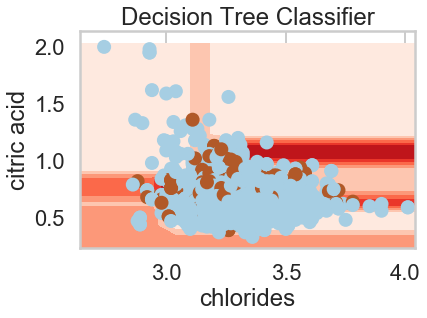

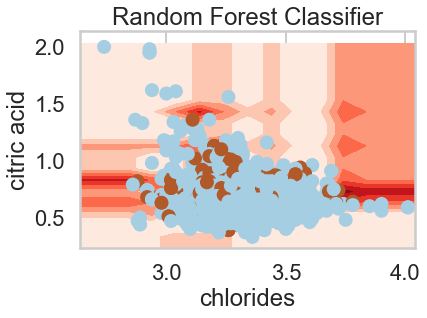

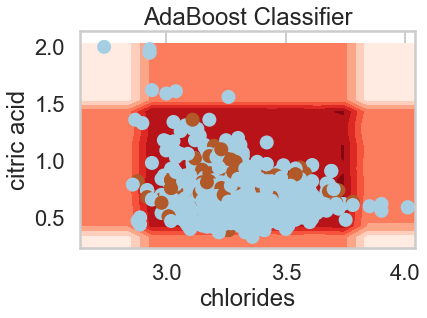

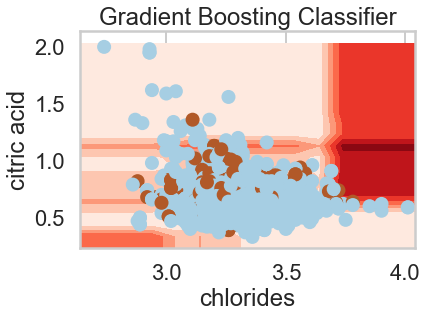

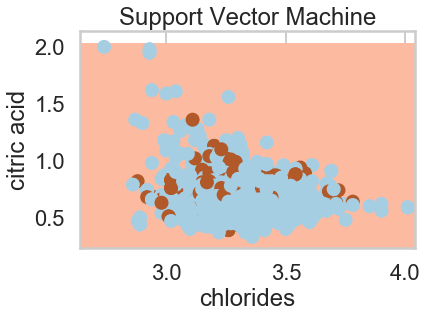

In [22]:
X_imp = df[['pH', 'sulphates']].values
Y = df.target.values

classifiers = [clfTree2,
               clfForest,
               clfAda,
               clfGB,
               sklearn.svm.SVC(C=100.0, gamma=1.0)]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier', 
                  'AdaBoost Classifier', 'Gradient Boosting Classifier', 'Support Vector Machine']
for c in range(5):
    plt.title(titleClassifer[c])
    plt.xlabel(name_list[0])
    plt.ylabel(name_list[1])
    plot_decision_surface(classifiers[c], X_imp, df.target.values)